# Load iNaturalist Dataset
We will be loading the validation dataset from iNaturalist 2021, as it is the smallest one. However the notebook is easily extendable for different splits.

Code has been extended and inspired from [tensorflow i_naturalist2021 dataset catalog](https://www.tensorflow.org/datasets/catalog/i_naturalist2021).

**THIS NOTEBOOK HAS BEEN UPDATED TO INCLUDE ONLY IMAGES THAT CONTAIN VERTEBRATE SPECIES**


**This notebook will be primary focusing on loading in the dataset and displaying some sample images.**

# Imports

In [ ]:
# For loading in dataset images and annotations
import json
import os

from etils import epath
import numpy as np
import tensorflow_datasets.public_api as tfds

# Displaying sample images
import itertools

import tarfile
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Loading dataset


In [ ]:
dm = tfds.download.DownloadManager(download_dir='/home')

URL = 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021'

# maps split type to split file name
SPLIT_FILENAMES = {
    'train': 'train',
    'mini': 'train_mini',
    'val': 'val',
    'test': 'public_test',
}

# Only load validation set
SPLIT = 'val'
SPLIT_FILE = SPLIT_FILENAMES[SPLIT]

# maps dataset to split tar & json files
splitDownloads = {}


In [ ]:
# download image tar file
splitDownloads[f'{SPLIT}_img'] =  tfds.download.Resource(
          url=f'{URL}/{SPLIT_FILE}.tar.gz',
          extract_method=tfds.download.ExtractMethod.NO_EXTRACT,
      )
# download json annotation file
splitDownloads[f'{SPLIT}_json'] = f'{URL}/{SPLIT_FILE}.json.tar.gz'

print(splitDownloads)

outputPaths = dm.download_and_extract(splitDownloads)

{'val_img': <tensorflow_datasets.core.download.resource.Resource object at 0x7fa411987130>, 'val_json': 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021/val.json.tar.gz'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

# Organising and Displaying Sample Images

### Compiling important annotations

In [ ]:
# paths to loaded dataset

imagesArchive = outputPaths[f'{SPLIT}_img']
jsonFile = os.path.join(outputPaths[f'{SPLIT}_json'],f'{SPLIT_FILE}.json')

In [ ]:
with epath.Path(jsonFile).open('r') as f:
      inatJson = json.load(f)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Functions to make our job easier:


In [ ]:
def format(label: str):
      # replace ' ' with '_' in a string
      return label.lower().replace(' ', '_')

# retrieves annotations (categories, id and image directory) for an image
def getAnnotation(idx, image_id):

      if 'annotations' in inatJson:

        # get the annotations object that matches our ID
        annotation = inatJson['annotations'][idx]
        assert annotation['image_id'] == image_id

        # retrieve 'categories' object corresponding to the id in the annotation object
        cat = inatJson['categories'][annotation['category_id']]

        # extract important metadata
        category = format(cat['name'])
        superCategory = format(cat['supercategory'])
        imageDirectory = cat['image_dir_name']

      else:
        # no metadata found
        category, superCategory, imageDirectory = -1, -1, -1

      return category, superCategory, imageDirectory

## Remove images that don't contain vertebrates

In [56]:
# List containing the vertebrates recognised by iNaturalist Dataset
vertebrates = ["jawless_fishes", "hagfishes", "lampreys", "ray-finned_fishes", "amphibians", "birds", "elasmobranchs", "chimaeras", "mammals", "reptiles", "lobe-finned_fishes"]

### Create collection of annotated images of vertebrates only
Using a dictionary, we will map each image file ID in the dataset to prioritised annotations.  

In [70]:
annotatedFiles = {}
count = 0
for idx, image in enumerate(inatJson['images']):

  category, superCategory, imageDirectory = getAnnotation(idx, image['id'])
  if superCategory in vertebrates:      # Checking if the species is a vertebrate
    field = os.path.basename(image['file_name']).split('.')[0]

    annotatedFiles[field] = {
        'id': image['id'],
        'file_id': field,
        'label': category,
        'superCategory': superCategory,
        'imagedirectory' : imageDirectory,
    }



>Slicing our dictionary as we only want to load 2 sample images.



In [58]:
print(len(annotatedFiles))          # Previously was 100000, now 23980

23980


In [60]:
NUM_SAMPLE_IMAGES = int(input("Enter the number of sample images you want to display: ")) 

annotatedFilesSliced = dict(itertools.islice(annotatedFiles.items(), NUM_SAMPLE_IMAGES))

print(len(annotatedFilesSliced))
print(annotatedFilesSliced)

5
{'df8edd4c-fbb4-4886-8600-a429e5efac23': {'id': 2686843, 'file_id': 'df8edd4c-fbb4-4886-8600-a429e5efac23', 'label': 'ptilotula_penicillata', 'superCategory': 'birds', 'imagedirectory': '03938_Animalia_Chordata_Aves_Passeriformes_Meliphagidae_Ptilotula_penicillata'}, 'fc35080c-5ace-4485-a21f-b1447f27efc7': {'id': 2686844, 'file_id': 'fc35080c-5ace-4485-a21f-b1447f27efc7', 'label': 'coccyzus_erythropthalmus', 'superCategory': 'birds', 'imagedirectory': '03583_Animalia_Chordata_Aves_Cuculiformes_Cuculidae_Coccyzus_erythropthalmus'}, '5a89f160-b085-4990-a66a-aac18059b7da': {'id': 2686846, 'file_id': '5a89f160-b085-4990-a66a-aac18059b7da', 'label': 'phoebastria_nigripes', 'superCategory': 'birds', 'imagedirectory': '04487_Animalia_Chordata_Aves_Procellariiformes_Diomedeidae_Phoebastria_nigripes'}, 'd5359888-d956-46a0-9dfb-87099ee1e6dc': {'id': 2686848, 'file_id': 'd5359888-d956-46a0-9dfb-87099ee1e6dc', 'label': 'mareca_americana', 'superCategory': 'birds', 'imagedirectory': '03253_Animal

### Displaying sample images

As all the images are stored in a tar.gz archive, we do not want to decompress the archive as it will take a lot of storage and processing time.

Instead, we will puzzle together the image file paths within the archive using the annotations we collected. Using these paths we can individually extract images we are interested in and display them in matplotlib.

In [61]:
# image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(imagesArchive, 'r')

except IOError as e:
  print(e)

else:

  for id,value in annotatedFilesSliced.items():
    # create image file path
    imgFilePath = f"val/{value['imagedirectory']}/{id}.jpg"
    imgToExtract.append(imgFilePath)

  t.extractall('/home', members=imgToExtract)


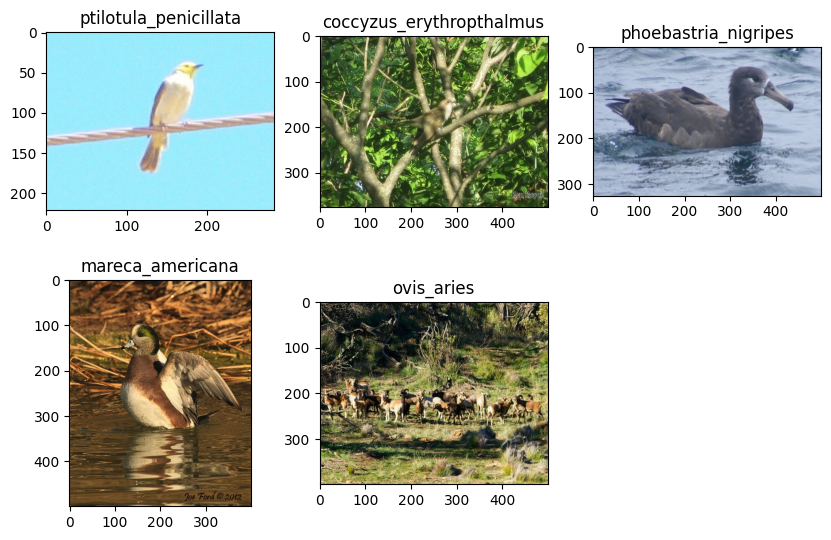

In [62]:
# display label with images

plt.figure(figsize=(10,10))
i = 0

for id,value in annotatedFilesSliced.items():
  ax = plt.subplot(3,3,i+1)
  plt.imshow(mpimg.imread("/home/" + imgToExtract[i]))
  plt.title(value['label'])
  i+=1
